In [5]:
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import torch, torch.nn as nn

import adsolver
import utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's just demonstrate that the solver produces something that resembles the QBO. We'll also check its amplitude, using the standard deviation at $25$ km as a metric.

In [12]:
solver = adsolver.ADSolver(z_min=17e3, z_max=35e3, dz=2.5e2, t_min=0, t_max=360*96*86400, dt=86400, w=0e-5, kappa=3e-1)
u = solver.solve().T


In [13]:
spinup_index = 12*360
padding_factor = 1  # 1 = no padding

ind_25 = (torch.abs(solver.z - 25.e3)).argmin()
ind_20 = (torch.abs(solver.z - 20.e3)).argmin()

u_smooth_25 = utils.butterworth_smoothing(u[ind_25, :], solver.time)
u_smooth_20 = utils.butterworth_smoothing(u[ind_20, :], solver.time)

amp25 = utils.estimate_amplitude(u_smooth_25[spinup_index:])
amp20 = utils.estimate_amplitude(u_smooth_20[spinup_index:])

u_smooth_25_padded = torch.hstack((u_smooth_25, torch.zeros(padding_factor*u_smooth_25.shape[0])))

tau25, dtau25 = utils.estimate_period(u_smooth_25_padded[spinup_index:], sample_rate=solver.dt/86400.)  # in units of days, assuming sample rate of 1 day -- devide by 30 to get period in months for a 360 day year
tau25 = tau25/30.
dtau25 = dtau25/30.


Standard deviation at 25km: 4.972


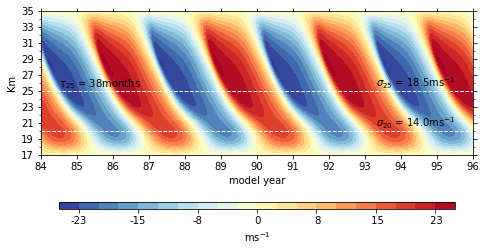

In [14]:
i_25km = abs(solver.z - 25e3).argmin()
print(f'Standard deviation at 25km: {u[:, i_25km].std():.3f}')
_, _ = utils.display(solver.time, solver.z, u.numpy(), amp25=amp25, amp20=amp20, tau25=tau25)

torch.Size([73, 34561])


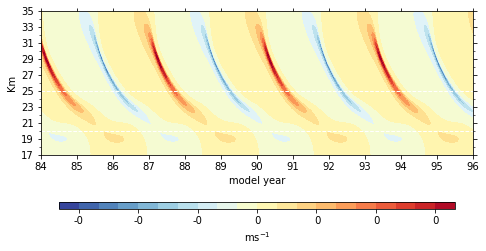

In [16]:
sfunc = utils.make_source_func(solver)
print(u.shape)
F = np.zeros_like(u)
for i in range(solver.time.shape[0]):
#     F[i, :] = sfunc(u[i, :]).numpy()
    F[:, i] = sfunc(u[:, i]).numpy()
_, _ = utils.display(solver.time, solver.z, F)


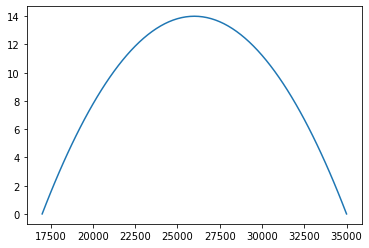

To test backpropagation through the numerical scheme, let's try and see if we can tune the wave amplitudes to produce an oscillation with a standard deviation of exactly $17.5$ m s$^{-1}$ (a rather arbitrary number, but you could imagine using observations here) at the $25$ km level. First, we'll spin the model up for 10 years. Then, for each iteration, we'll run the integration for 15 years, calculate the variance at the $25$ km level, and backpropagate on the difference between that variance and $17.5^2$.

In [3]:
solver = qboo.QBOSolver()
u_spunup = solver.solve(n_steps=(360 * 10))[-1]
b_func = lambda _: u_spunup

As = torch.tensor([4e-3, -4e-3]).requires_grad_()
dFdz_func = utils.make_dFdz_func(solver, As=As)

optimizer = torch.optim.Adam([As])
max_iters = 200

target_std = 17.5
def get_loss(u):
    return (u[:, i_25km].var() - target_std ** 2) ** 2

for n_iter in range(1, max_iters + 1):
    optimizer.zero_grad()
    
    u = solver.solve(
        n_steps=(360 * 15),
        dFdz_func=dFdz_func,
        b_func=b_func
    )
    
    loss = get_loss(u)
    loss.backward()
    optimizer.step()
    
    if n_iter % 10 == 0:
        print(f'Iteration {n_iter}: loss is {loss:.4f}')

Iteration 10: loss is 2787.5454
Iteration 20: loss is 355.3250
Iteration 30: loss is 16.9937
Iteration 40: loss is 108.0190
Iteration 50: loss is 21.6239
Iteration 60: loss is 2.9239
Iteration 70: loss is 0.0960
Iteration 80: loss is 0.0171
Iteration 90: loss is 0.1679
Iteration 100: loss is 0.1587
Iteration 110: loss is 0.0751
Iteration 120: loss is 0.0135
Iteration 130: loss is 0.0000
Iteration 140: loss is 0.0020
Iteration 150: loss is 0.0011
Iteration 160: loss is 0.0000
Iteration 170: loss is 0.0001
Iteration 180: loss is 0.0000
Iteration 190: loss is 0.0000
Iteration 200: loss is 0.0000


The loss seems pretty small. However, it could be that wave amplitudes giving the right QBO amplitude in training don't work for longer integrations. Let's check.

Standard deviation at 25km: 17.489


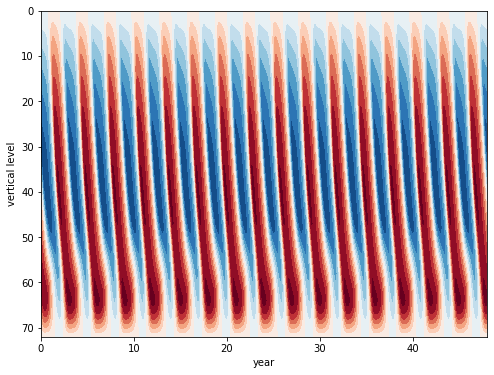

In [4]:
u = solver.solve(
    n_steps=(360 * 48),
    dFdz_func=utils.make_dFdz_func(solver, As=As.detach()),
    b_func=b_func
)

print(f'Standard deviation at 25km: {u[:, i_25km].std():.3f}')
_ = utils.display(u.numpy())